In [1]:
import numpy as np
import pandas as pd
import os
import radvel
from radvel.plot import orbit_plots, mcmc_plots
from scipy import optimize

%matplotlib inline

/Users/petigura/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _stats
/Users/petigura/anaconda2/lib/python2.7/site-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _ni_label


In [2]:
data = pd.read_csv(os.path.join(radvel.DATADIR,'k2-131.txt'), sep=' ')

t = np.array(data.time)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [3]:
print(radvel.gp.KERNELS)


{'SqExp': ['gp_length', 'gp_amp'], 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'], 'Per': ['gp_per', 'gp_length', 'gp_amp'], 'Celerite': ['1_logA', '1_logB', '1_logC', '1_logD']}


In [4]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]

In [5]:
gp_explength_mean = 9.5*np.sqrt(2.) # sqrt(2)*tau in Dai+ 2017 [days]
gp_explength_unc = 1.0*np.sqrt(2.)
gp_perlength_mean = np.sqrt(1./(2.*3.32)) # sqrt(1/(2*gamma)) in Dai+ 2017
gp_perlength_unc = 0.019
gp_per_mean = 9.64 # T_bar in Dai+ 2017 [days]
gp_per_unc = 0.12

Porb = 0.3693038 # orbital period [days]
Porb_unc = 0.0000091
Tc = 2457582.9360 # [BJD]
Tc_unc = 0.0011

In [6]:
nplanets=1
params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')

In [7]:
params['per1'] = radvel.Parameter(value=Porb)
params['tc1'] = radvel.Parameter(value=Tc)
params['sesinw1'] = radvel.Parameter(value=0.,vary=False) # fix eccentricity = 0
params['secosw1'] = radvel.Parameter(value=0.,vary=False)
params['k1'] = radvel.Parameter(value=6.55)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

In [8]:
params['gp_amp'] = radvel.Parameter(value=25.0)
params['gp_explength'] = radvel.Parameter(value=gp_explength_mean)
params['gp_per'] = radvel.Parameter(value=gp_per_mean)
params['gp_perlength'] = radvel.Parameter(value=gp_perlength_mean)

In [9]:
gpmodel = radvel.model.RVModel(params)


In [10]:
jit_guesses = {'harps-n':0.5, 'pfs':5.0}

likes = []
def initialize(tel_suffix):

    # Instantiate a separate likelihood object for each instrument.
    # Each likelihood must use the same radvel.RVModel object.
    indices = telgrps[tel_suffix]
    like = radvel.likelihood.GPLikelihood(gpmodel, t[indices], vel[indices],
                                          errvel[indices], hnames, suffix='_'+tel_suffix,
                                          kernel_name="QuasiPer"
                                          )
    # Add in instrument parameters
    like.params['gamma_'+tel_suffix] = radvel.Parameter(value=np.mean(vel[indices]))
    like.params['jit_'+tel_suffix] = radvel.Parameter(value=jit_guesses[tel_suffix])
    likes.append(like)


for tel in instnames:
    initialize(tel)

In [11]:
gplike = radvel.likelihood.CompositeLikelihood(likes)


In [12]:
gppost = radvel.posterior.Posterior(gplike)


In [13]:
gppost.priors += [radvel.prior.Gaussian('per1', Porb, Porb_unc)]
gppost.priors += [radvel.prior.Gaussian('tc1', Tc, Tc_unc)]
gppost.priors += [radvel.prior.Jeffreys('k1', 0.01, 10.)] # min and max for Jeffrey's priors estimated by Sarah
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 100.)]
gppost.priors += [radvel.prior.Jeffreys('jit_pfs', 0.01, 10.)]
gppost.priors += [radvel.prior.Jeffreys('jit_harps-n', 0.01,10.)]
gppost.priors += [radvel.prior.Gaussian('gp_explength', gp_explength_mean, gp_explength_unc)]
gppost.priors += [radvel.prior.Gaussian('gp_per', gp_per_mean, gp_per_unc)]
gppost.priors += [radvel.prior.Gaussian('gp_perlength', gp_perlength_mean, gp_perlength_unc)]

In [14]:
res = optimize.minimize(
    gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)

print(gppost)

/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: xatol
  This is separate from the ipykernel package so we can avoid doing imports until


parameter                     value      vary
per1                       0.369302       True
tc1                         7582.94       True
secosw1                           0      False
sesinw1                           0      False
k1                          6.74824       True
dvdt                              0      False
curv                              0      False
gp_amp                      23.0453       True
gp_explength                13.3689       True
gp_per                       9.6254       True
gp_perlength               0.381483       True
gamma_harps-n              -6694.18       True
jit_harps-n                    0.01       True
gamma_pfs                  -7.27619       True
jit_pfs                      4.4742       True

Priors
------
Gaussian prior on per1, mu=0.3693038, sigma=9.1e-06
Gaussian prior on tc1, mu=2457582.936, sigma=0.0011
Jeffrey's prior on k1, min=0.01, max=10.0
Jeffrey's prior on gp_amp, min=0.01, max=100.0
Jeffrey's prior on jit_pfs, min=0.01, max

In [16]:
chains = radvel.mcmc(gppost,nrun=10000,ensembles=3)


172500/1500000 (11.5%) steps complete; Running 3624.76 steps/s; Mean acceptance rate = 37.0%; Min Tz = 111.4; Max G-R = 1.028      
Discarding burn-in now that the chains are marginally well-mixed

532500/1500000 (35.5%) steps complete; Running 3212.98 steps/s; Mean acceptance rate = 35.5%; Min Tz = 1160.8; Max G-R = 1.003      
Chains are well-mixed after 532500 steps! MCMC completed in 2.6 minutes




Populating the interactive namespace from numpy and matplotlib


(-50.0, 50)

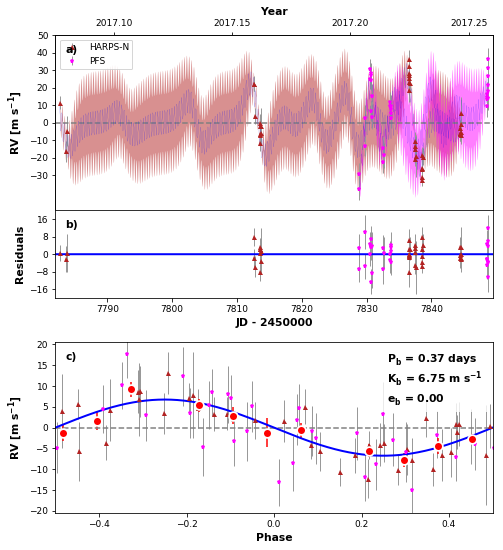

In [22]:
%pylab inline
# try switching some of these (optional) keywords to "True" to see what they do!
GPPlot = orbit_plots.GPMultipanelPlot(
    gppost,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False,
    subtract_orbit_model=False
)
GPPlot.plot_multipanel()
ax = gcf().get_axes()[0]
sca(ax)
ylim(-50.,50)

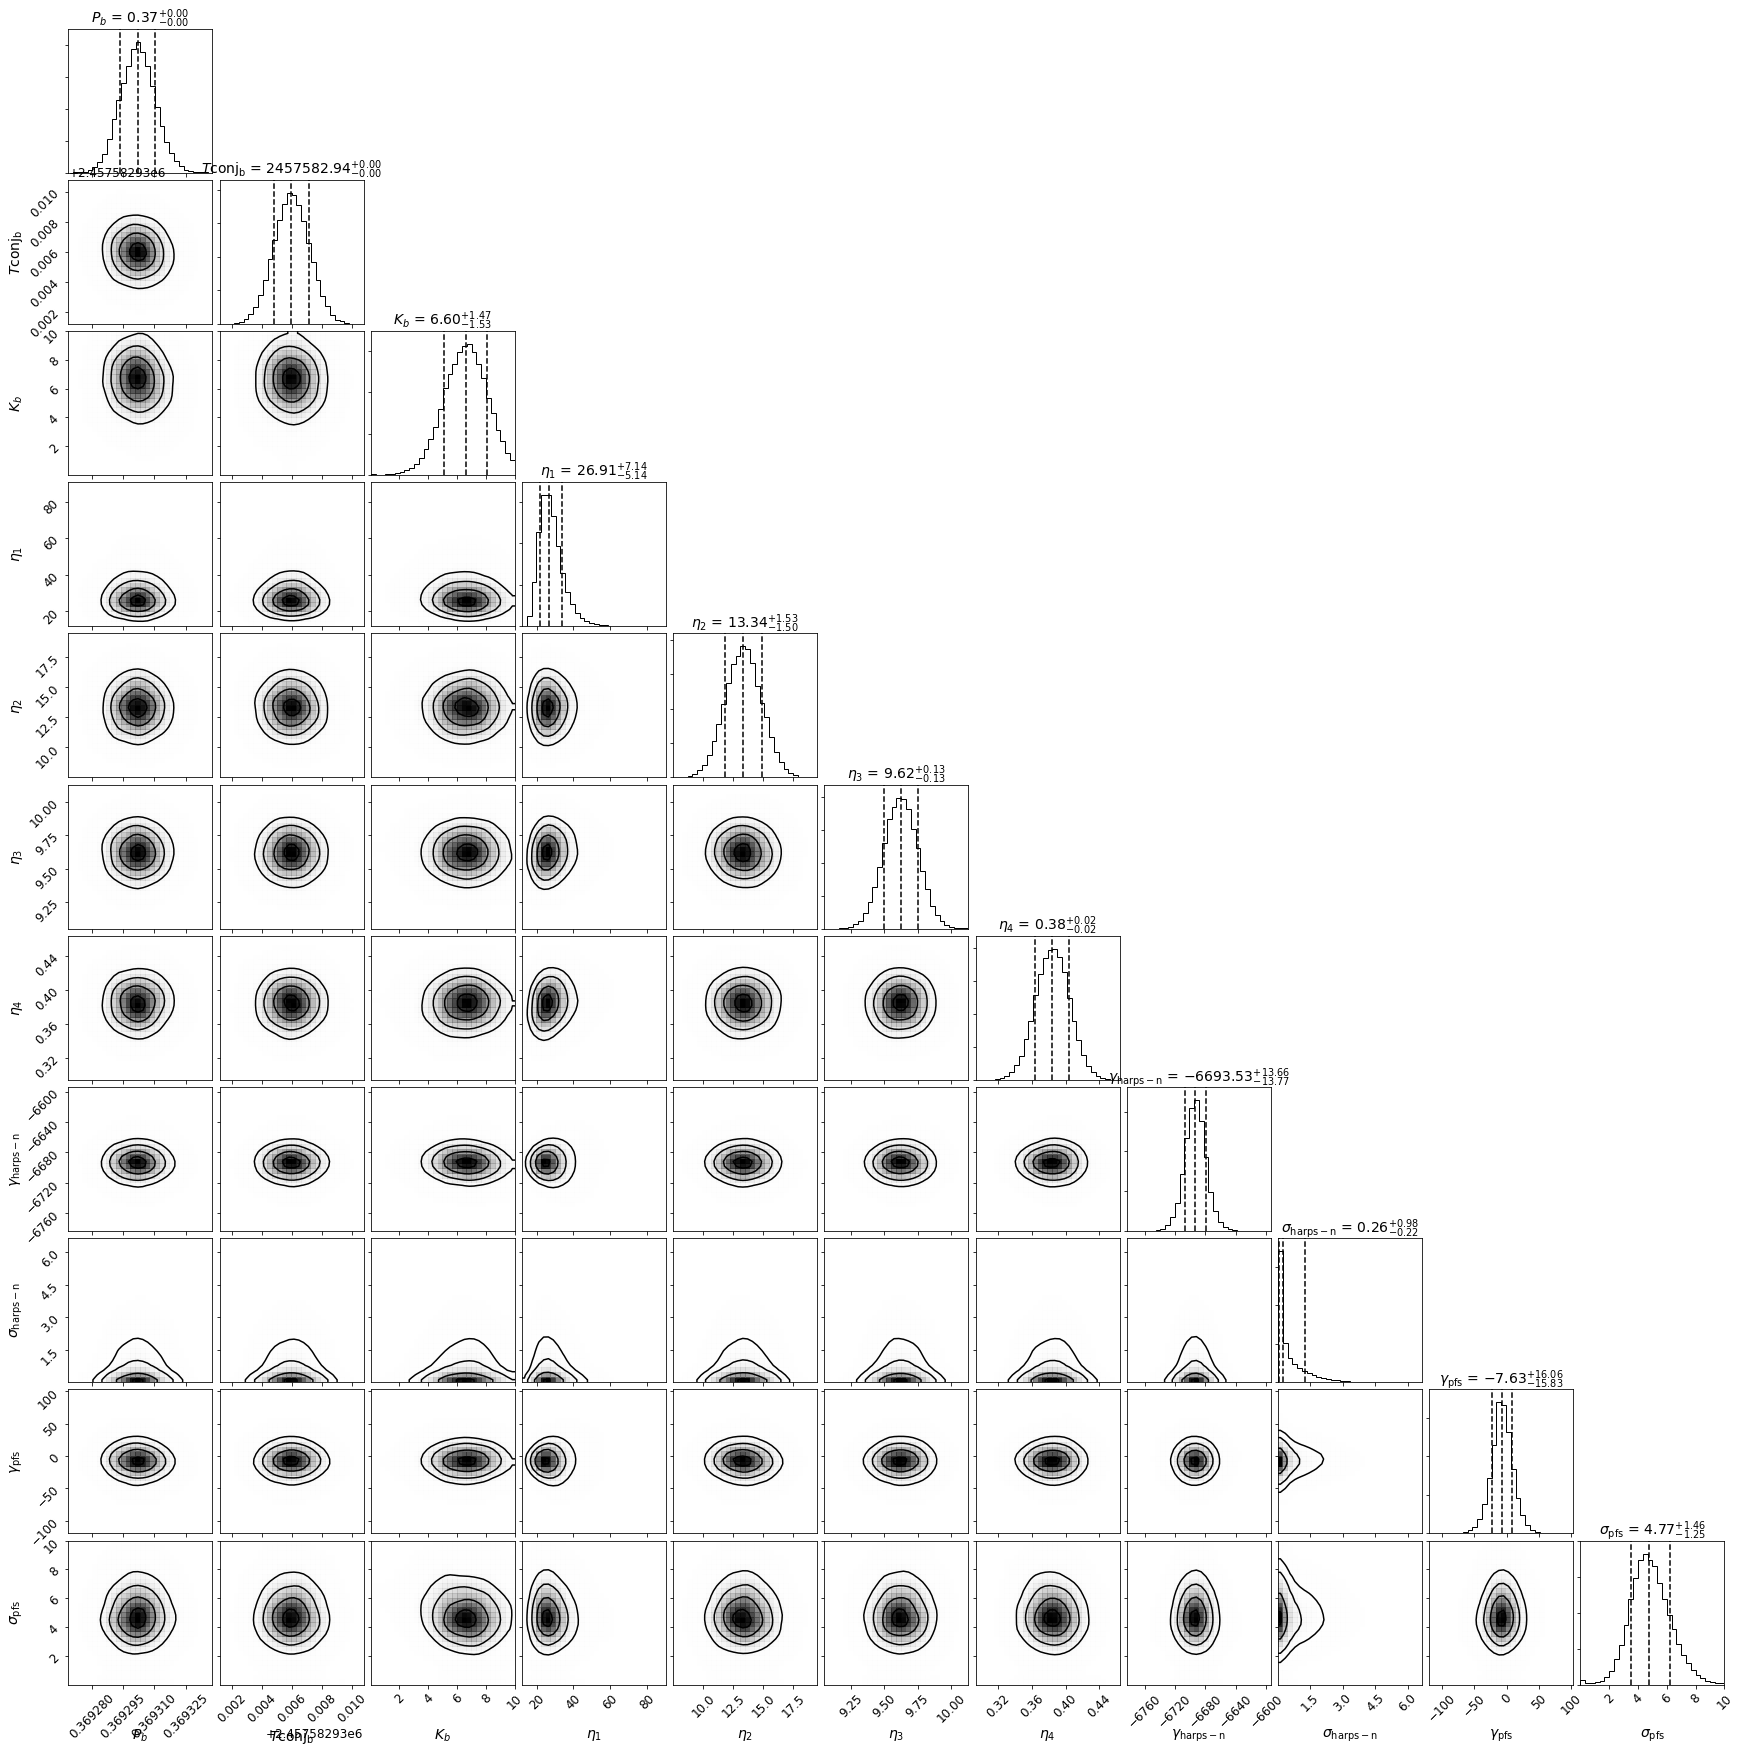

In [23]:
Corner = mcmc_plots.CornerPlot(gppost, chains) # posterior distributions
Corner.plot()